<a href="https://colab.research.google.com/github/SawsanYusuf/Housing-in-Colombia/blob/main/4_Price_with_everything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+3"><strong>Predicting Price with Everything</strong></font>

In [ ]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

# Import

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    #Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace= True)

    return df

Let’s begin by loading all our CSV files into a DataFrame

In [ ]:
files = glob("/content/colombia-real-estate-*.csv")
files

['/content/colombia-real-estate-4.csv',
 '/content/colombia-real-estate-3.csv',
 '/content/colombia-real-estate-2.csv',
 '/content/colombia-real-estate-5.csv',
 '/content/colombia-real-estate-1.csv']

We need to put all our DataFrames into a list. To achieve this, we’re going to
use a more compact coding technique called a **list comprehension**.

In [ ]:
frames = [wrangle(file) for file in files]

Last step: Combine the DataFrames in frames into a single df.

In [ ]:
df = pd.concat(frames, ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4126 non-null   object 
 1   property_type               4126 non-null   object 
 2   price                       4126 non-null   float64
 3   currency                    4126 non-null   object 
 4   price_aprox_local_currency  4126 non-null   float64
 5   price_aprox_usd             4126 non-null   float64
 6   surface_total_in_m2         1688 non-null   float64
 7   surface_covered_in_m2       4126 non-null   float64
 8   price_usd_per_m2            1688 non-null   float64
 9   price_per_m2                4126 non-null   float64
 10  floor                       2704 non-null   float64
 11  rooms                       3352 non-null   float64
 12  expenses                    1 non-null      float64
 13  properati_url               4126 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,rent,house,5000000.0,COP,5039118.44,1688.26,NaN,150.0,NaN,33333.333333,NaN,2.0,NaN,http://chapinero-bogota-d-c.properati.com.co/j...,4.635,-74.062,Chapinero
1,rent,house,45000000.0,COP,45352185.42,15194.38,NaN,350.0,NaN,128571.428571,NaN,NaN,NaN,http://engativa-bogota-d-c.properati.com.co/jm...,4.696,-74.094,Engativa
2,rent,house,7500000.0,COP,7558677.67,2532.39,NaN,143.0,NaN,52447.552448,NaN,3.0,NaN,http://usaquen-bogota-d-c.properati.com.co/jm4...,4.667,-74.050,Usaquén
3,rent,house,8000000.0,COP,8062601.45,2701.22,NaN,258.0,NaN,31007.751938,1.0,3.0,NaN,http://chapinero-bogota-d-c.properati.com.co/j...,4.677,-74.045,Chapinero
4,rent,house,5000000.0,COP,5039118.44,1688.26,NaN,87.0,NaN,57471.264368,1.0,2.0,NaN,http://chapinero-bogota-d-c.properati.com.co/j...,4.677,-74.045,Chapinero


## Explore

The first thing we need to consider when trying to use all the features df is **missing values**. A general rule is that, if more than half of the data in a column is missing, it’s better to drop it then try imputing.

In [ ]:
# Check null values
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.590887
surface_covered_in_m2         0.000000
price_usd_per_m2              0.590887
price_per_m2                  0.000000
floor                         0.344644
rooms                         0.187591
expenses                      0.999758
properati_url                 0.000000
lat                           0.000000
lon                           0.000000
neighborhood                  0.000000
dtype: float64

We need to modify our wrangle function to drop any columns that are more than half NaN
values.

In [ ]:
# Drop features with high null counts
df.drop(columns = ["floor","expenses"], inplace= True)

The next thing we need to look out for are categorical columns with low or high **cardinality**. If
there’s only one category in a column, it won’t provide any unique information to our model. At
the other extreme, columns where nearly every row has its own category won’t help our model in
identifying useful trends in the data.
Let’s take a look at the cardinality of our features.

In [ ]:
df.select_dtypes("object").nunique()

operation           2
property_type       1
currency            1
properati_url    4126
neighborhood       20
dtype: int64

Here, we can see that columns like `"operation"` have tow value in them, while every row
in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality
features that we shouldn’t include in our model.

We must modifying our wrangle function to drop these high- and low-cardinality categorical features.

In [ ]:
#Drop low and high cardinality categorical variables
df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)

It’s also important for us to drop any columns that would constitute **leakage**, that is, features that
were created using our target or that would give our model information that it won’t have access
to when it’s deployed

In [ ]:
#Drop Leakey columns
df.drop(columns= [
                  "price",
                  "price_aprox_local_currency",
                  "price_per_m2",
                  "price_usd_per_m2"
                 ],
  inplace= True)

Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our
feature matrix that are highly correlated with each other. A good way to detect this is to use a
heatmap.

Let's plot a correlation heatmap of the remaining numerical features in df. Since
`"price_aprox_usd"` will be our target, we don’t need to include it in our **heatmap**.

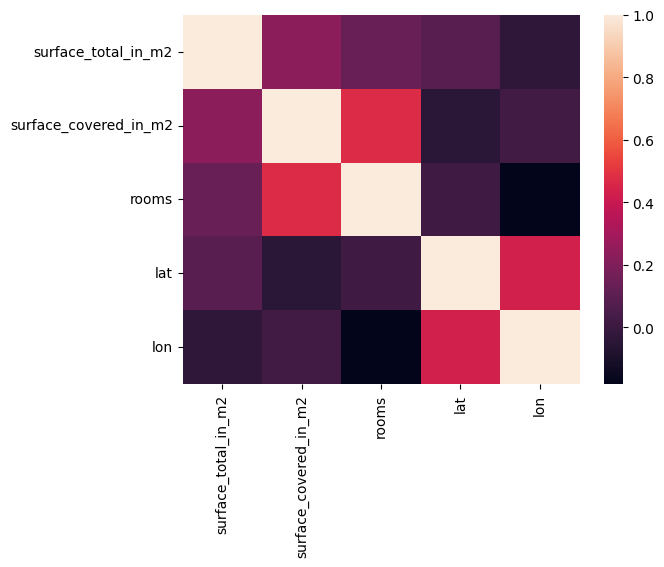

In [ ]:
corr = df.select_dtypes("number").drop(columns= "price_aprox_usd").corr()
sns.heatmap(corr);

We will modify our wrangle function to remove columns so that there are no strongly correlated features in our feature matrix.

In [ ]:
#Drop columns with multicollinearity
df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

The final version of our wrangle function and DataFrame:

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    #Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace= True)

    # Drop features with high null counts
    df.drop(columns = ["floor","expenses"], inplace= True)
    #Drop low and high cardinality categorical variables
    df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)
    #Drop Leakey columns
    df.drop(columns= [
                      "price",
                      "price_aprox_local_currency",
                      "price_per_m2",
                      "price_usd_per_m2"
                    ],
    inplace= True)
    #Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

In [ ]:
files = glob("/content/colombia-real-estate-*.csv")
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        4126 non-null   float64
 1   surface_covered_in_m2  4126 non-null   float64
 2   lat                    4126 non-null   float64
 3   lon                    4126 non-null   float64
 4   neighborhood           4126 non-null   object 
dtypes: float64(4), object(1)
memory usage: 161.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,1688.26,150.0,4.635,-74.062,Chapinero
1,15194.38,350.0,4.696,-74.094,Engativa
2,2532.39,143.0,4.667,-74.050,Usaquén
3,2701.22,258.0,4.677,-74.045,Chapinero
4,1688.26,87.0,4.677,-74.045,Chapinero


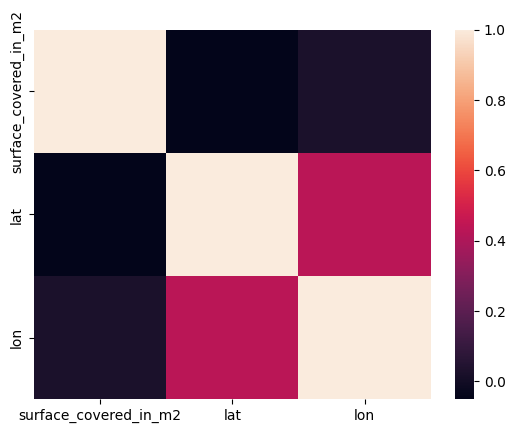

In [ ]:
corr = df.select_dtypes("number").drop(columns= "price_aprox_usd").corr()
sns.heatmap(corr);

## Split

Let's create our feature matrix `X_train` and target vector `y_train`. our target is
`"price_aprox_usd"`. our features is all the columns that remain in the DataFrame we
cleaned above.

In [ ]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train= df[features]
y_train = df[target]

# Build Model

## Baseline

In [ ]:
y_mean= y_train.mean()
y_pred_baseline =[y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 66403.66
Baseline MAE: 86347.16145862668


## Iterate

Let's create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`,
and `Ridge` predictor.

In [ ]:
model = make_pipeline(
           OneHotEncoder(use_cat_names=True),
           SimpleImputer(),
           Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

Calculating the training mean absolute error for your predictions as compared to the
true targets in `y_train`.

In [ ]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 84203.94103184494


# Results

In many data science projects, however, communication means giving stakeholders tools they can
use to deploy a model — in other words, use it in action. So let’s look at two ways you might
deploy this model.

One thing you might be asked to do it wrap your model in a **function** so that a programmer can
provide inputs and then receive a prediction as output.

In [ ]:
def make_prediction(area, lat, lon, neighborhood):
  data = {
  "surface_covered_in_m2" :area,
  "lat": lat,
  "lon": lon,
  "neighborhood": neighborhood
  }
  df = pd.DataFrame(data, index = [0])
  prediction = model.predict(df).round(2)[0]
  return f"Predicted apartment price: ${prediction}"

Let’s see if your function works.

In [ ]:
make_prediction(160, 4.715, -74.095, "Suba")

'Predicted apartment price: $90081.74'

Another type of deployment is creating an interactive **dashboard**, where a user can supply values
and receive a prediction. Let’s create one using **Jupyter Widgets**.

In [ ]:
interact(
    make_prediction,
    area=IntSlider(
          min=X_train["surface_covered_in_m2"].min(),
          max=X_train["surface_covered_in_m2"].max(),
          value=X_train["surface_covered_in_m2"].mean(),
),

    lat=FloatSlider(
         min=X_train["lat"].min(),
         max=X_train["lat"].max(),
         step=0.01,
         value=X_train["lat"].mean(),
),

    lon=FloatSlider(
         min=X_train["lon"].min(),
         max=X_train["lon"].max(),
         step=0.01,
         value=X_train["lon"].mean(),
),

    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=135, description='area', max=495, min=45), FloatSlider(value=4.687857965…